El siguiente codigo es para visualizar la forma de la funcion

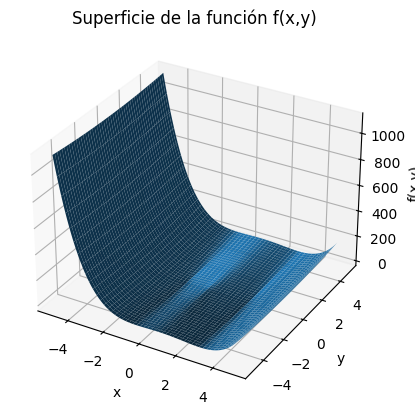

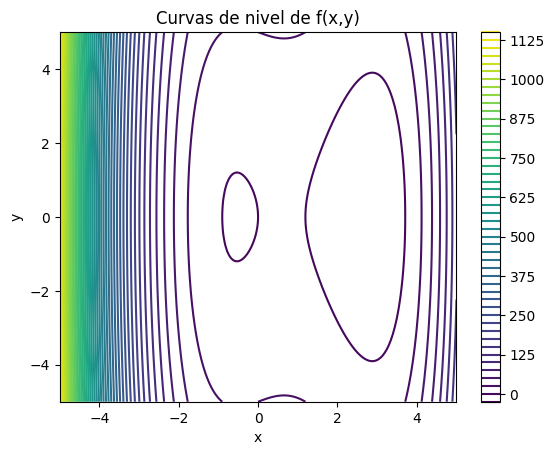

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f(x, y):
    return x**4 - 4*x**3 + 4*x + y**2

x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x,y)")
plt.title("Superficie de la función f(x,y)")
plt.show()


plt.contour(X, Y, Z, levels=50)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Curvas de nivel de f(x,y)")
plt.colorbar()
plt.show()


El siguiente codigo es para generar un conjunto de 300 puntos que se utilizaran para realizar el analisis de ambos algoritmos

In [1]:
import numpy as np
import pandas as pd
import random

def generar_puntos_fijos(n_por_region=100, semilla=42):
    """
    Genera 300 puntos distribuidos en 3 regiones del dominio [-100, 100].

    Regiones:
    1. x1 < 0
    2. 0 < x1 < 2
    3. x1 > 2

    En todas las regiones: x2 ∈ [-100, 100]
    """
    np.random.seed(semilla)
    random.seed(semilla)

    puntos = []

    # REGIÓN 1: x1 < 0
    for _ in range(n_por_region):
        x1 = np.random.uniform(-100, 0)
        x2 = np.random.uniform(-100, 100)
        puntos.append([x1, x2, 1])

    # REGIÓN 2: 0 < x1 < 2
    for _ in range(n_por_region):
        x1 = np.random.uniform(0, 2)
        x2 = np.random.uniform(-100, 100)
        puntos.append([x1, x2, 2])

    # REGIÓN 3: x1 > 2
    for _ in range(n_por_region):
        x1 = np.random.uniform(2, 100)
        x2 = np.random.uniform(-100, 100)
        puntos.append([x1, x2, 3])

    return np.array(puntos)


puntos_array = generar_puntos_fijos()

df_simple = pd.DataFrame(puntos_array, columns=['x1', 'x2', 'region'])
df_simple = df_simple.sort_values(['region', 'x1']).reset_index(drop=True)

nombre_archivo = 'puntos_coordenadas.csv'
df_simple.to_csv(nombre_archivo, index=False)

print(f"Archivo guardado: {nombre_archivo}")
print(f"Total puntos: {len(df_simple)}")


Archivo guardado: puntos_coordenadas.csv
Total puntos: 300


Realizando el algoritmo de gradiente descendiente normal, con distintos lr

In [1]:
import numpy as np
import pandas as pd

def f(x):
    return x[0]**4 - 4*x[0]**3 + 4*x[0] + x[1]**2

def grad_f(x):
    return np.array([4*x[0]**3 - 12*x[0]**2 + 4, 2*x[1]])

# -----------------------------
# Descenso por Gradiente
# -----------------------------
def gradient_descent(x0, lr=0.01, tol=1e-6, max_iter=800):
    x = np.array(x0, dtype=float)
    history = [x.copy()]
    
    for iteration in range(max_iter):
        g = grad_f(x)
        x_new = x - lr * g
        history.append(x_new.copy())
        
        if np.linalg.norm(x_new - x) < tol:
            break
            
        x = x_new
    
    x_final = history[-1]
    f_final = f(x_final)
    
    return x_final, f_final, len(history) - 1  # x_final, f_final, iteraciones

# --------------------------------------------------
# Cargar los puntos desde el CSV
# --------------------------------------------------
def cargar_puntos_desde_csv(archivo='puntos_coordenadas.csv'):
    """Carga los puntos generados anteriormente"""
    df = pd.read_csv(archivo)
    puntos = []
    
    for idx, row in df.iterrows():
        punto_id = f"P{idx:03d}"  # Crear ID: P000, P001, etc.
        x0 = [row['x1'], row['x2']]
        region = int(row['region'])
        puntos.append({
            'id': punto_id,
            'x0': x0,
            'region': region,
            'x1_inicial': x0[0],
            'x2_inicial': x0[1]
        })
    
    print(f"Cargados {len(puntos)} puntos desde '{archivo}'")
    return puntos

# --------------------------------------------------
# Ejecutar experimentos con múltiples learning rates
# --------------------------------------------------
def ejecutar_experimentos_gd(puntos, learning_rates, max_iter=200):
    """
    Ejecuta GD con diferentes learning rates para todos los puntos
    
    Args:
        puntos: Lista de puntos iniciales
        learning_rates: Lista de learning rates a probar
        max_iter: Máximo de iteraciones por ejecución
    """
    resultados = []
    
    
    for i, punto in enumerate(puntos):
        x0 = punto['x0']
        punto_id = punto['id']
        region = punto['region']
        
        print(f"Procesando {punto_id} (Región {region}): [{x0[0]:.2f}, {x0[1]:.2f}]")
        
        for lr in learning_rates:
            # Ejecutar GD
            try:
                x_final, f_final, iteraciones = gradient_descent(
                    x0, lr=lr, tol=1e-6, max_iter=max_iter
                )
                
                # Determinar si convergió o no
                convergio = iteraciones < max_iter
                
                # Calcular distancia al origen (opcional)
                distancia = np.linalg.norm(x_final)
                
                # Guardar resultados
                resultados.append({
                    'punto_id': punto_id,
                    'region': region,
                    'x1_inicial': x0[0],
                    'x2_inicial': x0[1],
                    'learning_rate': lr,
                    'x1_final': x_final[0],
                    'x2_final': x_final[1],
                    'f_final': f_final,
                    'iteraciones': iteraciones,
                    'convergio': convergio,
                    'distancia_final': distancia,
                    'max_iter_alcanzado': (iteraciones == max_iter)
                })
                
            except Exception as e:
                print(f"  ERROR con lr={lr}: {str(e)}")
                resultados.append({
                    'punto_id': punto_id,
                    'region': region,
                    'x1_inicial': x0[0],
                    'x2_inicial': x0[1],
                    'learning_rate': lr,
                    'x1_final': np.nan,
                    'x2_final': np.nan,
                    'f_final': np.nan,
                    'iteraciones': 0,
                    'convergio': False,
                    'distancia_final': np.nan,
                    'max_iter_alcanzado': True
                })
    
    return resultados

# --------------------------------------------------
# Análisis y guardado de resultados
# --------------------------------------------------
def guardar_resultados_csv(resultados, archivo_salida='resultados_gd.csv'):
    """Guarda los resultados en un archivo CSV"""
    df_resultados = pd.DataFrame(resultados)
    
    # Guardar CSV
    df_resultados.to_csv(archivo_salida, index=False)
    
    print(f"\n{'='*60}")
    print(f"RESULTADOS GUARDADOS EN: {archivo_salida}")
    print(f"Total de ejecuciones: {len(df_resultados)}")
    print(f"{'='*60}")
    
    return df_resultados

# --------------------------------------------------
# EJECUCIÓN PRINCIPAL
# --------------------------------------------------
def main():
    # 1. Cargar puntos iniciales
    print("CARGANDO PUNTOS INICIALES...")
    puntos = cargar_puntos_desde_csv('puntos_coordenadas.csv')
    
    # 2. Definir learning rates a probar
    learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
    print(f"\nLearning rates a probar: {learning_rates}")
    
    # 3. Ejecutar experimentos
    resultados = ejecutar_experimentos_gd(puntos, learning_rates, max_iter=2400)
    
    # 4. Guardar resultados
    df_resultados = guardar_resultados_csv(resultados, 'resultados_gd_completo.csv')
        
    return df_resultados

# --------------------------------------------------
# Ejecutar el programa principal
# --------------------------------------------------
if __name__ == "__main__":
    # Ejecutar todos los experimentos
    df_resultados = main()
    
    

CARGANDO PUNTOS INICIALES...
Cargados 300 puntos desde 'puntos_coordenadas.csv'

Learning rates a probar: [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
Procesando P000 (Región 1): [-99.45, 63.09]


c:\Users\marti\AppData\Local\Programs\Python\Python314\Lib\site-packages\numpy\linalg\_linalg.py:2792: RuntimeWarning: overflow encountered in dot
  sqnorm = x.dot(x)
C:\Users\marti\AppData\Local\Temp\ipykernel_10944\1837826729.py:8: RuntimeWarning: overflow encountered in scalar power
  return np.array([4*x[0]**3 - 12*x[0]**2 + 4, 2*x[1]])
C:\Users\marti\AppData\Local\Temp\ipykernel_10944\1837826729.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  return np.array([4*x[0]**3 - 12*x[0]**2 + 4, 2*x[1]])


Procesando P001 (Región 1): [-99.30, 2.15]
Procesando P002 (Región 1): [-97.94, 93.98]
Procesando P003 (Región 1): [-97.46, -78.42]
Procesando P004 (Región 1): [-96.86, 27.28]
Procesando P005 (Región 1): [-96.56, 81.86]
Procesando P006 (Región 1): [-95.92, 18.18]
Procesando P007 (Región 1): [-95.48, -34.93]
Procesando P008 (Región 1): [-94.85, -44.27]
Procesando P009 (Región 1): [-94.19, 73.24]
Procesando P010 (Región 1): [-93.49, 89.78]
Procesando P011 (Región 1): [-92.54, 97.38]
Procesando P012 (Región 1): [-91.15, -60.80]
Procesando P013 (Región 1): [-90.97, 67.06]
Procesando P014 (Región 1): [-90.69, 79.44]
Procesando P015 (Región 1): [-88.04, 42.65]


C:\Users\marti\AppData\Local\Temp\ipykernel_10944\1837826729.py:8: RuntimeWarning: overflow encountered in scalar multiply
  return np.array([4*x[0]**3 - 12*x[0]**2 + 4, 2*x[1]])


Procesando P016 (Región 1): [-88.01, -32.48]
Procesando P017 (Región 1): [-87.80, -0.96]
Procesando P018 (Región 1): [-85.91, 60.44]
Procesando P019 (Región 1): [-85.51, -2.11]
Procesando P020 (Región 1): [-84.40, -68.80]
Procesando P021 (Región 1): [-81.82, -63.32]
Procesando P022 (Región 1): [-80.03, 2.85]
Procesando P023 (Región 1): [-77.21, -14.58]
Procesando P024 (Región 1): [-77.12, -84.60]
Procesando P025 (Región 1): [-76.24, 45.64]
Procesando P026 (Región 1): [-74.21, 32.00]
Procesando P027 (Región 1): [-74.12, 32.50]
Procesando P028 (Región 1): [-71.91, 8.54]
Procesando P029 (Región 1): [-71.52, -92.62]
Procesando P030 (Región 1): [-71.02, -67.76]
Procesando P031 (Región 1): [-70.79, -26.73]
Procesando P032 (Región 1): [-69.58, 4.95]
Procesando P033 (Región 1): [-69.54, -80.47]
Procesando P034 (Región 1): [-68.90, -34.96]
Procesando P035 (Región 1): [-68.83, 4.01]
Procesando P036 (Región 1): [-68.56, 1.71]
Procesando P037 (Región 1): [-68.20, -77.99]
Procesando P038 (Región 1)

C:\Users\marti\AppData\Local\Temp\ipykernel_10944\1837826729.py:19: RuntimeWarning: invalid value encountered in subtract
  x_new = x - lr * g


Procesando P041 (Región 1): [-65.89, -77.31]
Procesando P042 (Región 1): [-64.15, -76.83]
Procesando P043 (Región 1): [-63.64, 94.36]
Procesando P044 (Región 1): [-63.22, 26.46]
Procesando P045 (Región 1): [-62.55, 90.14]
Procesando P046 (Región 1): [-61.13, -45.73]
Procesando P047 (Región 1): [-58.96, 51.11]
Procesando P048 (Región 1): [-58.26, -55.58]
Procesando P049 (Región 1): [-56.81, -41.75]
Procesando P050 (Región 1): [-54.39, 57.04]
Procesando P051 (Región 1): [-50.28, -39.82]
Procesando P052 (Región 1): [-48.79, -54.70]
Procesando P053 (Región 1): [-48.12, 40.60]
Procesando P054 (Región 1): [-47.73, -14.49]
Procesando P055 (Región 1): [-47.03, -51.63]
Procesando P056 (Región 1): [-45.33, -63.03]
Procesando P057 (Región 1): [-40.76, -90.71]
Procesando P058 (Región 1): [-40.21, 84.37]
Procesando P059 (Región 1): [-39.89, 41.61]
Procesando P060 (Región 1): [-39.25, -65.90]
Procesando P061 (Región 1): [-39.04, 0.54]
Procesando P062 (Región 1): [-38.81, -72.10]
Procesando P063 (Reg

Ejecutando analisis estadistico sobre los resultados obtenidos para poder llegar a conclusiones

In [2]:
import numpy as np
import pandas as pd


# ==========================================================
#   FUNCIONES AUXILIARES DE ESTADÍSTICAS
# ==========================================================

def flatten_columns(df):
    """Convierte MultiIndex de columnas en nombres planos."""
    df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]
    return df


def calcular_stats_general(df):
    """Genera estadísticas generales por región y learning_rate."""
    
    stats = df.groupby(['region', 'learning_rate']).agg({
        'iteraciones': ['mean', 'std', 'min', 'max', 'count'],
        'f_final': ['mean', 'std', 'min', 'max'],
        'convergio': ['mean', 'sum']
    })

    stats = flatten_columns(stats)
    
    stats["conv_percent"] = (stats["convergio_mean"] * 100).round(2)
    stats["total_ejecuciones"] = stats["iteraciones_count"]
    stats["no_conv_count"] = stats["total_ejecuciones"] - stats["convergio_sum"]

    # Eficiencia solo para convergencias
    df_conv = df[df['convergio'] == 1]
    if not df_conv.empty:
        conv_stats = df_conv.groupby(['region', 'learning_rate'])['iteraciones'].agg(['mean', 'std'])
        conv_stats.columns = ["conv_iter_mean", "conv_iter_std"]
        stats = stats.join(conv_stats)

    return stats.reset_index()



def calcular_stats_convergencias(df):
    """Estadísticas solo para convergencias."""
    df_conv = df[df['convergio'] == 1]
    if df_conv.empty:
        return pd.DataFrame()  # No hay convergencias

    stats = df_conv.groupby(['region', 'learning_rate']).agg({
        'iteraciones': ['mean', 'std', 'min', 'max', 'count'],
        'f_final': ['mean', 'std', 'min', 'max'],
    })

    return flatten_columns(stats).reset_index()



def clasificar_no_convergencia(row):
    """Clasifica razones de fallo."""
    f = row['f_final']

    if row['max_iter_alcanzado'] == 1:
        if pd.isna(f) or np.isinf(f) or f > 1e10:
            return "divergencia_overflow"
        return "lento_max_iter"

    if pd.isna(f) or np.isinf(f):
        return "error_numerico"

    return "otro"


def calcular_stats_no_convergencias(df):
    """Estadísticas para puntos que NO convergieron."""
    
    df_no = df[df['convergio'] == 0].copy()
    if df_no.empty:
        return pd.DataFrame()

    df_no["razon_fallo"] = df_no.apply(clasificar_no_convergencia, axis=1)

    stats = df_no.groupby(['region', 'learning_rate', 'razon_fallo']).agg({
        'iteraciones': ['mean', 'count'],
        'f_final': ['mean', 'std'],
        'x1_inicial': ['mean', 'std'],
        'x2_inicial': ['mean', 'std'],
    })

    return flatten_columns(stats).reset_index()



def calcular_stats_divergencias(df):
    """Estadísticas para divergencias fuertes (overflow/crecimiento explosivo)."""
    
    df_div = df[
        (df['max_iter_alcanzado'] == 1) &
        ((df['f_final'].isna()) | (df['f_final'] > 1e10))
    ].copy()

    if df_div.empty:
        return pd.DataFrame()

    df_div["tipo_divergencia"] = df_div.apply(
        lambda row: "overflow" if pd.isna(row['f_final']) else "crecimiento_explosivo",
        axis=1
    )

    stats = pd.DataFrame({
        "total_divergencias": [len(df_div)],
        "porcentaje_total": [len(df_div) / len(df) * 100],
        "overflow_count": [len(df_div[df_div["tipo_divergencia"] == "overflow"])],
        "crecimiento_count": [len(df_div[df_div["tipo_divergencia"] == "crecimiento_explosivo"])],
        "lr_mas_comun": [df_div["learning_rate"].mode().iloc[0]],
        "region_mas_comun": [df_div["region"].mode().iloc[0]],
        "x1_mean": [df_div["x1_inicial"].mean()],
        "x1_std": [df_div["x1_inicial"].std()],
        "x2_mean": [df_div["x2_inicial"].mean()],
        "x2_std": [df_div["x2_inicial"].std()],
    }).round(4)

    return stats



# ==========================================================
#   FUNCIÓN PRINCIPAL
# ==========================================================

def analizar_y_generar_4_csv(archivo_entrada="resultados_gd_completo.csv"):
    print(f"📥 Cargando datos desde: {archivo_entrada}")

    df = pd.read_csv(archivo_entrada)
    print(f"✅ Datos cargados: {len(df)} ejecuciones\n")

    print("📊 Generando CSV 1: análisis general...")
    stats_general = calcular_stats_general(df)
    stats_general.to_csv("analisis_general.csv", index=False)

    print("📊 Generando CSV 2: estadísticas de convergencias...")
    stats_conv = calcular_stats_convergencias(df)
    stats_conv.to_csv("estadisticas_convergencias.csv", index=False)

    print("📊 Generando CSV 3: estadísticas de NO convergencias...")
    stats_no_conv = calcular_stats_no_convergencias(df)
    stats_no_conv.to_csv("estadisticas_no_convergencias.csv", index=False)

    print("📊 Generando CSV 4: estadísticas de divergencias...")
    stats_div = calcular_stats_divergencias(df)
    stats_div.to_csv("estadisticas_divergencias.csv", index=False)

    print("\n✅ ANÁLISIS COMPLETADO")
    print("📁 CSV generados:")
    print(" - analisis_general.csv")
    print(" - estadisticas_convergencias.csv")
    print(" - estadisticas_no_convergencias.csv")
    print(" - estadisticas_divergencias.csv")


# ==========================================================
#   EJECUCIÓN DIRECTA
# ==========================================================

if __name__ == "__main__":
    analizar_y_generar_4_csv()


📥 Cargando datos desde: resultados_gd_completo.csv
✅ Datos cargados: 2400 ejecuciones

📊 Generando CSV 1: análisis general...
📊 Generando CSV 2: estadísticas de convergencias...
📊 Generando CSV 3: estadísticas de NO convergencias...
📊 Generando CSV 4: estadísticas de divergencias...

✅ ANÁLISIS COMPLETADO
📁 CSV generados:
 - analisis_general.csv
 - estadisticas_convergencias.csv
 - estadisticas_no_convergencias.csv
 - estadisticas_divergencias.csv


Lo siguiente seria el codigo de ejecución del algoritmo de gradiente descendiente con la condición de armijo

In [3]:
import numpy as np
import pandas as pd

# ================================================================
# FUNCIÓN OBJETIVO Y GRADIENTE
# ================================================================
def f(x):
    return x[0]**4 - 4*x[0]**3 + 4*x[0] + x[1]**2

def grad_f(x):
    return np.array([4*x[0]**3 - 12*x[0]**2 + 4, 2*x[1]])


# ================================================================
# BACKTRACKING + ARMIJO
# ================================================================
def backtracking_armijo(x, g, alpha0=1.0, beta=0.5, c=1e-4):
    """Retorna paso alpha que cumple Armijo."""
    alpha = alpha0
    fx = f(x)
    g_norm_sq = np.dot(g, g)

    while f(x - alpha * g) > fx - c * alpha * g_norm_sq:
        alpha *= beta
    
    return alpha


# ================================================================
# GRADIENT DESCENT CON BÚSQUEDA EN LÍNEA
# ================================================================
def gradient_descent_armijo(x0, tol=1e-6, max_iter=200,
                            alpha0=1.0, beta=0.5, c=1e-4):

    x = np.array(x0, dtype=float)
    history = [x.copy()]
    
    for k in range(max_iter):

        g = grad_f(x)

        # criterio de parada por gradiente pequeño
        if np.linalg.norm(g) < tol:
            break
        
        # línea de búsqueda Armijo
        alpha = backtracking_armijo(x, g, alpha0, beta, c)
        
        x_new = x - alpha * g
        history.append(x_new.copy())

        if np.linalg.norm(x_new - x) < tol:
            break
        
        x = x_new
    
    return x, np.array(history), k + 1


# ================================================================
# CARGA DE PUNTOS
# ================================================================
def cargar_puntos_desde_csv(archivo='puntos_coordenadas.csv'):
    df = pd.read_csv(archivo)
    puntos = []

    for idx, row in df.iterrows():
        puntos.append({
            'id': f"P{idx:03d}",
            'x0': [row['x1'], row['x2']],
            'region': int(row['region'])
        })
    
    print(f"Cargados {len(puntos)} puntos desde {archivo}")
    return puntos


# ================================================================
# EXPERIMENTOS SOBRE PARÁMETROS DE ARMIJO
# ================================================================
def ejecutar_experimentos_armijo(puntos, alpha0_list, beta_list, c_list,
                                 max_iter=200):

    resultados = []

    for punto in puntos:
        punto_id = punto["id"]
        x0 = punto["x0"]
        region = punto["region"]

        print(f"Procesando {punto_id} (región {region})")

        for a0 in alpha0_list:
            for beta in beta_list:
                for c in c_list:

                    try:
                        x_final, hist, iters = gradient_descent_armijo(
                            x0, tol=1e-6, max_iter=max_iter,
                            alpha0=a0, beta=beta, c=c
                        )

                        convergio = (iters < max_iter)
                        f_final = f(x_final)

                        resultados.append({
                            "punto_id": punto_id,
                            "region": region,
                            "x1_inicial": x0[0],
                            "x2_inicial": x0[1],
                            "alpha0": a0,
                            "beta": beta,
                            "c": c,
                            "x1_final": x_final[0],
                            "x2_final": x_final[1],
                            "f_final": f_final,
                            "iteraciones": iters,
                            "convergio": convergio,
                            "distancia_final": np.linalg.norm(x_final)
                        })
                    
                    except Exception as e:
                        print(f"ERROR con parámetros a0={a0}, beta={beta}, c={c}: {e}")
                        resultados.append({
                            "punto_id": punto_id,
                            "region": region,
                            "x1_inicial": x0[0],
                            "x2_inicial": x0[1],
                            "alpha0": a0,
                            "beta": beta,
                            "c": c,
                            "x1_final": np.nan,
                            "x2_final": np.nan,
                            "f_final": np.nan,
                            "iteraciones": 0,
                            "convergio": False,
                            "distancia_final": np.nan
                        })

    return resultados


# ================================================================
# GUARDAR RESULTADOS
# ================================================================
def guardar_resultados_csv(resultados, archivo='resultados_armijo.csv'):
    df = pd.DataFrame(resultados)
    df.to_csv(archivo, index=False)

    print("="*60)
    print(f"CSV GENERADO: {archivo}")
    print(f"Total ejecuciones: {len(df)}")
    print("="*60)

    return df


# ================================================================
# PROGRAMA PRINCIPAL
# ================================================================
def main():
    puntos = cargar_puntos_desde_csv('puntos_coordenadas.csv')

    # RANGOS DE PARÁMETROS A PROBAR
    alpha0_list = [1.0, 0.8, 0.5]
    beta_list   = [0.5, 0.7]
    c_list      = [1e-4, 1e-3]

    resultados = ejecutar_experimentos_armijo(
        puntos, alpha0_list, beta_list, c_list, max_iter=2000
    )

    df = guardar_resultados_csv(resultados, "resultados_armijo_completo.csv")
    return df


if __name__ == "__main__":
    main()


Cargados 300 puntos desde puntos_coordenadas.csv
Procesando P000 (región 1)
Procesando P001 (región 1)
Procesando P002 (región 1)
Procesando P003 (región 1)
Procesando P004 (región 1)
Procesando P005 (región 1)
Procesando P006 (región 1)
Procesando P007 (región 1)
Procesando P008 (región 1)
Procesando P009 (región 1)
Procesando P010 (región 1)
Procesando P011 (región 1)
Procesando P012 (región 1)
Procesando P013 (región 1)
Procesando P014 (región 1)
Procesando P015 (región 1)
Procesando P016 (región 1)
Procesando P017 (región 1)
Procesando P018 (región 1)
Procesando P019 (región 1)
Procesando P020 (región 1)
Procesando P021 (región 1)
Procesando P022 (región 1)
Procesando P023 (región 1)
Procesando P024 (región 1)
Procesando P025 (región 1)
Procesando P026 (región 1)
Procesando P027 (región 1)
Procesando P028 (región 1)
Procesando P029 (región 1)
Procesando P030 (región 1)
Procesando P031 (región 1)
Procesando P032 (región 1)
Procesando P033 (región 1)
Procesando P034 (región 1)
Proces

A continuacion se procesan los datos obtenidos de la ejecucion del algoritmo

In [4]:
import pandas as pd
import numpy as np

def analizar_resultados_armijo(archivo='resultados_armijo_completo.csv',
                               archivo_salida='estadisticas_armijo.csv'):
    """
    Lee los resultados crudos del algoritmo con Armijo y genera estadísticas
    para analizar convergencia y comportamiento por parámetros.
    """

    df = pd.read_csv(archivo)

    print(f"Resultados cargados: {df.shape[0]} ejecuciones")

    # ==============================
    # 1. Identificar convergencia
    # ==============================
    df['convergio'] = df['convergio'].astype(bool)

    # ==============================
    # 2. Estadísticas por combinación de parámetros
    # ==============================
    # Agrupamos por los parámetros del algoritmo
    stats = df.groupby(['alpha0', 'beta', 'c']).agg(
        total_ejecuciones=('convergio', 'count'),
        convergieron=('convergio', 'sum'),
        no_convergieron=('convergio', lambda x: (~x).sum()),

        # estadísticas solo de los casos convergidos
        iter_promedio=('iteraciones', 'mean'),
        iter_min=('iteraciones', 'min'),
        iter_max=('iteraciones', 'max'),

        f_final_prom=('f_final', 'mean'),
        f_final_min=('f_final', 'min'),
        f_final_max=('f_final', 'max'),

        # distancia final (al mínimo)
        dist_prom=('distancia_final', 'mean'),

    ).reset_index()

    # ==============================
    # 3. Porcentaje de convergencia
    # ==============================
    stats['tasa_convergencia_%'] = (
        stats['convergieron'] / stats['total_ejecuciones'] * 100
    ).round(2)

    # ==============================
    # 4. Guardar CSV
    # ==============================
    stats.to_csv(archivo_salida, index=False)

    print("\n=======================================")
    print(f"ESTADÍSTICAS GUARDADAS EN: {archivo_salida}")
    print("=======================================")

    return stats


# EJECUCIÓN DIRECTA
if __name__ == "__main__":
    analizar_resultados_armijo()


Resultados cargados: 3600 ejecuciones

ESTADÍSTICAS GUARDADAS EN: estadisticas_armijo.csv


A partir de los puntos ejecutados se escogieron 3 puntos relevantes, uno de cada region y se les va ahacer un analisis grafico a los 3

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# =======================================================
# FUNCIÓN OBJETIVO Y GRADIENTE
# =======================================================

def funcion_f(x):
    return x[0]**4 - 4*x[0]**3 + 4*x[0] + x[1]**2

def grad_funcion_f(x):
    return np.array([
        4*x[0]**3 - 12*x[0]**2 + 4,
        2*x[1]
    ])

# =======================================================
# BACKTRACKING ARMijo
# =======================================================

def backtracking_armijo(x, g, alpha0, beta, c):
    alpha = alpha0
    fx = funcion_f(x)

    while funcion_f(x - alpha * g) > fx - c * alpha * np.dot(g, g):
        alpha *= beta
    return alpha

# =======================================================
# DESCENSO POR GRADIENTE (PASO FIJO)
# =======================================================

def gradient_descent_con_historial(x0, lr=0.01, tol=1e-6, max_iter=800):
    x = np.array(x0, dtype=float)
    history = [x.copy()]
    grad_norms = []

    for _ in range(max_iter):
        g = grad_funcion_f(x)
        grad_norms.append(np.linalg.norm(g))

        x_new = x - lr * g
        history.append(x_new.copy())

        if np.linalg.norm(x_new - x) < tol:
            break

        x = x_new

    return {
        "x_final": x,
        "f_final": funcion_f(x),
        "iteraciones": len(history) - 1,
        "history": np.array(history),
        "grad_norms": np.array(grad_norms)
    }

# =======================================================
# DESCENSO POR GRADIENTE CON ARMIJO
# =======================================================

def gradient_descent_armijo_con_historial(
    x0, tol=1e-6, max_iter=200,
    alpha0=1.0, beta=0.5, c=1e-4
):
    x = np.array(x0, dtype=float)
    history = [x.copy()]
    grad_norms = []

    for _ in range(max_iter):
        g = grad_funcion_f(x)
        grad_norms.append(np.linalg.norm(g))

        if np.linalg.norm(g) < tol:
            break

        alpha = backtracking_armijo(x, g, alpha0, beta, c)
        x_new = x - alpha * g
        history.append(x_new.copy())

        if np.linalg.norm(x_new - x) < tol:
            break

        x = x_new

    return {
        "x_final": x,
        "f_final": funcion_f(x),
        "iteraciones": len(history) - 1,
        "history": np.array(history),
        "grad_norms": np.array(grad_norms)
    }

# =======================================================
# CREAR CARPETA DE GRÁFICAS
# =======================================================

os.makedirs("graficas", exist_ok=True)

# =======================================================
# 1️⃣ CURVAS DE NIVEL + TRAYECTORIAS
# =======================================================

def graficar_trayectorias_con_historial(
    x0, lr=0.1, xlim=(-1,4), ylim=(-4,4)
):
    """
    Grafica las trayectorias de GD con lr fijo y GD con Armijo
    sobre curvas de nivel de la función objetivo.
    El dominio de las curvas es FIJO para evitar problemas
    cuando el método diverge (ej. lr = 0.3).
    """

    import numpy as np
    import matplotlib.pyplot as plt
    import os

    # --------------------------------------------------
    # Asegurar carpeta de salida
    # --------------------------------------------------
    os.makedirs("graficas", exist_ok=True)

    # --------------------------------------------------
    # Dominio FIJO para curvas de nivel
    # (no depende de la trayectoria)
    # --------------------------------------------------
    X, Y = np.meshgrid(
        np.linspace(xlim[0], xlim[1], 400),
        np.linspace(ylim[0], ylim[1], 400)
    )
    Z = X**4 - 4*X**3 + 4*X + Y**2

    # --------------------------------------------------
    # Ejecutar métodos
    # --------------------------------------------------
    res_gd = gradient_descent_con_historial(x0, lr=lr)
    res_arm = gradient_descent_armijo_con_historial(x0)

    hist_gd = res_gd["history"]
    hist_arm = res_arm["history"]

    # --------------------------------------------------
    # Recorte SOLO para visualización (evita overflow)
    # --------------------------------------------------
    mask_gd = (
        (np.abs(hist_gd[:,0]) < 10) &
        (np.abs(hist_gd[:,1]) < 10)
    )
    mask_arm = (
        (np.abs(hist_arm[:,0]) < 10) &
        (np.abs(hist_arm[:,1]) < 10)
    )

    # --------------------------------------------------
    # Gráfica
    # --------------------------------------------------
    plt.figure(figsize=(8, 6))

    plt.contour(X, Y, Z, levels=30, cmap="viridis")
    plt.colorbar(label="f(x, y)")

    plt.plot(
        hist_gd[mask_gd, 0],
        hist_gd[mask_gd, 1],
        "o-",
        markersize=3,
        linewidth=1,
        label="GD fijo"
    )

    plt.plot(
        hist_arm[mask_arm, 0],
        hist_arm[mask_arm, 1],
        "s-",
        markersize=3,
        linewidth=1,
        label="Armijo"
    )

    plt.scatter(x0[0], x0[1], color="black", zorder=5, label="Inicio")

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Trayectorias sobre curvas de nivel (lr = {lr})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # --------------------------------------------------
    # Guardar figura
    # --------------------------------------------------
    plt.savefig(f"graficas/trayectorias_lr_{lr}.png", dpi=300)
    plt.close()


# =======================================================
# 2️⃣ f(x) VS ITERACIONES
# =======================================================

def graficar_f_vs_iter_con_historial(x0, lr=0.1):
    res_gd = gradient_descent_con_historial(x0, lr=lr)
    res_arm = gradient_descent_armijo_con_historial(x0)

    f_gd = [funcion_f(x) for x in res_gd["history"]]
    f_arm = [funcion_f(x) for x in res_arm["history"]]

    plt.figure(figsize=(8,5))
    plt.plot(f_gd, label="GD fijo")
    plt.plot(f_arm, label="Armijo")
    plt.xlabel("Iteración")
    plt.ylabel("f(x)")
    plt.title(f"Valor de la función vs iteraciones (lr={lr})")
    plt.legend()
    plt.grid(True)

    plt.savefig(f"graficas/f_vs_iter_lr_{lr}.png", dpi=300)
    plt.close()

# =======================================================
# 3️⃣ NORMA DEL GRADIENTE VS ITERACIONES
# =======================================================

def graficar_gradiente_vs_iter_con_historial(x0, lr=0.1):
    res_gd = gradient_descent_con_historial(x0, lr=lr)
    res_arm = gradient_descent_armijo_con_historial(x0)

    plt.figure(figsize=(8,5))
    plt.plot(res_gd["grad_norms"], label="GD fijo")
    plt.plot(res_arm["grad_norms"], label="Armijo")
    plt.yscale("log")
    plt.xlabel("Iteración")
    plt.ylabel(r"$\|\nabla f(x_k)\|$")
    plt.title(f"Norma del gradiente vs iteraciones (lr={lr})")
    plt.legend()
    plt.grid(True)

    plt.savefig(f"graficas/gradiente_vs_iter_lr_{lr}.png", dpi=300)
    plt.close()

# =======================================================
# EJECUCIÓN
# =======================================================

if __name__ == "__main__":
    x0 = np.array([1.0226847977218756, 0.30325893743992083])

    for lr in [0.1, 0.3]:
        graficar_trayectorias_con_historial(x0, lr=lr, xlim=(-1,4), ylim=(-2,2))
        graficar_f_vs_iter_con_historial(x0, lr=lr)
        graficar_gradiente_vs_iter_con_historial(x0, lr=lr)


C:\Users\marti\AppData\Local\Temp\ipykernel_4796\4281303946.py:15: RuntimeWarning: overflow encountered in scalar power
  4*x[0]**3 - 12*x[0]**2 + 4,
C:\Users\marti\AppData\Local\Temp\ipykernel_4796\4281303946.py:15: RuntimeWarning: invalid value encountered in scalar subtract
  4*x[0]**3 - 12*x[0]**2 + 4,
C:\Users\marti\AppData\Local\Temp\ipykernel_4796\4281303946.py:11: RuntimeWarning: overflow encountered in scalar power
  return x[0]**4 - 4*x[0]**3 + 4*x[0] + x[1]**2
C:\Users\marti\AppData\Local\Temp\ipykernel_4796\4281303946.py:11: RuntimeWarning: invalid value encountered in scalar subtract
  return x[0]**4 - 4*x[0]**3 + 4*x[0] + x[1]**2
